In [1]:
import sys
print(sys.version)
from datetime import datetime
import pandas as pd

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [2]:
!pip install -Uqq praw

!pip install -Uqq transformers

In [3]:
import praw

reddit = praw.Reddit(client_id='ItAL1O4jvc6e-4L7rjMDmA',
                    client_secret='yrXcz0-MWZMFUHj_N4cOFjowxRSksw',
                    username= 'Infinite-Strength-90',
                    password = '@z4QjYYPUz9bziS',
                    user_agent='myuseragent')
print(reddit.user.me())

Infinite-Strength-90


In [4]:
def searchSubreddit(subred, query):
    subreddit = reddit.subreddit(subred)
    commentsList = []
    for submission in subreddit.search(query, limit=30):
        submission.comments.replace_more(limit=0)
        commentsFlatten =  submission.comments.list()
        for c in commentsFlatten:
            time = datetime.utcfromtimestamp(c.created_utc)
            commentsList.append({"Comment Time" : time,
                                 "Comment Body" : c.body})
    return commentsList

In [5]:
data = searchSubreddit("wallstreetbets", "AVTI OR Activision OR Blizzard OR Microsoft")
comments_df = pd.DataFrame(data)

In [6]:
comments_df = comments_df.drop_duplicates()
comments_df = comments_df[comments_df["Comment Body"].str.len() < 512]

In [7]:
comments_df.to_csv('raw_wall.csv')

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

# text = "Good night 😊"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

1) positive 0.8466
2) neutral 0.1458
3) negative 0.0076


In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [10]:
def sentiment_analysis(text):
    processed_text = preprocess(text)
    encoded_input = tokenizer(processed_text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    return scores

In [11]:
sentiment_analysis(comments_df['Comment Body'].iloc[0])

array([0.13617648, 0.20724884, 0.65657467], dtype=float32)

In [12]:
comments_df['Sentiment Scores'] = comments_df['Comment Body'].apply(sentiment_analysis)

In [13]:
def prob_to_label(scores):
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    return labels[ranking[0]]
       
prob_to_label(comments_df['Sentiment Scores'].iloc[0])

'positive'

In [14]:
comments_df['Sentiment'] = comments_df['Sentiment Scores'].apply(prob_to_label)

In [15]:
comments_df.to_csv('sen_wall.csv', index=False)

In [16]:
comments_df['Comment Time'] = pd.to_datetime(comments_df['Comment Time'])
grouped = comments_df.groupby([pd.Grouper(key='Comment Time', freq='D'),'Sentiment']).size().reset_index(name='count')

# 创建pivot table，其中行是日期，列是情感类别，值是计数
pivot_table = grouped.pivot_table(index='Comment Time', columns='Sentiment', values='count', fill_value=0)

# 确保所有情感类别的列都存在，即使某些类别在某天没有评论
pivot_table = pivot_table.reindex(columns=['positive', 'neutral', 'negative'], fill_value=0)

# 将 'date' 索引转换为列
pivot_table.reset_index(inplace=True)

In [17]:
pivot_table['total'] = pivot_table['positive'] + pivot_table['neutral'] + pivot_table['negative']
pivot_table["positive_rate"] = pivot_table["positive"] / pivot_table["total"]
pivot_table["negative_rate"] = pivot_table["negative"] / pivot_table["total"]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


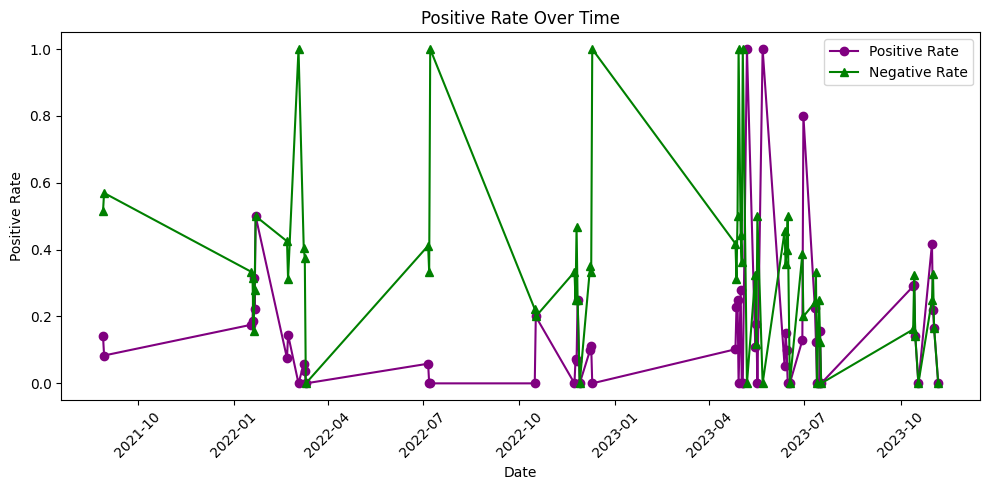

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(pivot_table['Comment Time'], pivot_table['positive_rate'], label='Positive Rate', color='purple', marker='o')
plt.plot(pivot_table['Comment Time'], pivot_table['negative_rate'], label='Negative Rate', color='green', marker='^')
plt.title('Positive Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Positive Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
pivot_table.to_csv("Result_WS)